In [1]:
from datasets import load_dataset

ds = load_dataset("iamwarint/wongnai-restaurant-review")

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['review_body', 'stars'],
        num_rows: 19458
    })
    test: Dataset({
        features: ['review_body', 'stars'],
        num_rows: 500
    })
})

In [3]:
from datasets import concatenate_datasets

data = concatenate_datasets([ds['train'],ds['test']])

In [4]:
data

Dataset({
    features: ['review_body', 'stars'],
    num_rows: 19958
})

In [5]:
df = data.to_pandas()

In [6]:
df.sample(n=10, random_state=42)

,review_body,stars
971,ไก่ทอดเจ้าดัง เลยลองสั่งมาทาน โดยใช้ GRAP ส่งฟ...,4
606,หนึ่งในร้านดังสุดของเมืองพัทยา​ ร้านใหญ่มากๆ​...,3
7197,ไปบางปู ไปกินอะไรดี คำถามยอดฮิตพอค้นข้อมูลไปข้...,5
695,มารอบนี้เป็นครั้งที่สอง เพราะอยากทานปลาเก๋าที่...,4
18346,หลังจากที่ไม่ได้ทานข้าวมันไก่เป็นเวลานานมาก วั...,3
6935,ขอฝากเพจ world food critic ของผมด้วยนะครับ \nฝ...,3
6291,เป็นบรรยากาศเหมือนนั่งร้านข้างทางแต่ไฮโซ 555 \...,4
17526,มากินบุฟเฟต์ราคา 700++ กินได้ทั้ง ซาชิมิ ซูชิ ...,5
7479,ร้าน arno's butcher ตั้งอยู่บนย่านสาทร เป็นร้า...,3
11993,วันนี้ลองไปทานเรดซันคนเดียวโดยใช้คูปองไลน์ จาก...,2


In [7]:
df.to_csv("Raw_data.csv", index=False, encoding="utf-8-sig")
# ส่งออก data

In [ ]:
import pandas as pd

# สร้าง df ใหม่จาก df เดิม 
df_binary = df.copy()
df_binary = df_binary[df_binary["stars"] != 3]  # ตัดรีวิว 3 ดาวออก


# map ดาวเป็น sentiment 
df_binary["sentiment"] = df_binary["stars"].apply(lambda x: "negative" if x <= 2 else "positive")

# ตรวจสอบผลลัพธ์
df_binary.sample(n=10, random_state=42)


,review_body,stars,sentiment
99,อาหารทะเล ราคาไม่แพง บรรยากาศดีๆ \nไม่วุ่นวาย...,4,positive
3659,คือเราเคยกินสาขานาเกลือแล้ว1 ก็ยังไม่โดนใจเท่า...,5,positive
19249,-อาหาร(Food)⭐️⭐️⭐️⭐️⭐️\nจากเกียรติศัพท์เลื่องล...,5,positive
15562,ร้านอยู่ในซอย​ เหมือนเป็นบ้านแล้งนำมาเปิดเป็นร...,5,positive
7474,ร้านนี้ตามกระแสวงในมาจริงๆค่ะ ได้ยินว่าต้องจอง...,4,positive
15875,ได้ยินชื่อเสียงเค้กเปี่ยมสุขมาสักพักละ เพิ่งจะ...,4,positive
18435,ร้านเจ้าเก่าย่านดังสุดบางรักมิเชอลินไกด์ยกนิ้ว...,5,positive
17063,เราไปร้านนี้ตั้งแต่เริ่มเปิดใหม่ที่มีจำนวนโต๊ะ...,5,positive
17432,ตามชื่อร้านเลยคะ เบอร์เกอร์ เป็นตัวเด่นของทางร...,5,positive
8323,Chocolate Ville ร้านอาหารสไตล์ยุโรป มีการจัดตก...,5,positive


In [9]:
from sklearn.model_selection import train_test_split

# แบ่ง train (70%) และ test (30%)
train_df, temp_df = train_test_split(df_binary, test_size=0.3, random_state=42, shuffle=True)

# จาก test (30%) แบ่งครึ่งอีกทีเป็น val (10%) และ test (20%)
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42, shuffle=True)

print(f"Train: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")


Train: 10890
Val:   1556
Test:  3112


In [10]:
train_path = "train_og_data.csv"
val_path   = "validate_data.csv"
test_path  = "test_data.csv"

train_df.to_csv(train_path, index=False, encoding="utf-8-sig")
val_df.to_csv(val_path, index=False, encoding="utf-8-sig")
test_df.to_csv(test_path, index=False, encoding="utf-8-sig")

In [11]:
train_df["sentiment"].value_counts()

sentiment
positive    10161
negative      729
Name: count, dtype: int64

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch


In [13]:
model_id = "scb10x/llama3.1-typhoon2-8b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
# ฟังก์ชันสร้าง prompt สำหรับ "new sample"

def build_messages_newsample(sentiment: str):
    return [
        {
            "role": "system",
            "content": (
                "คุณคือนักเขียนรีวิวร้านอาหารหรือคาเฟ่มืออาชีพ "
                "หน้าที่ของคุณคือการเขียนรีวิวใหม่ทั้งหมด (new sample) "
                "โดยใช้อารมณ์ข้อความที่กำหนดให้ "
                "นำเมนูอาหาร หรือ เครื่องดื่ม มาใช้สร้างรีวิวได้"
                "เขียนให้จบเป็นย่อหน้าเดียว สร้างรีวิวจบภายใน 70–110 คำ "
                "หากใช้อีโมจิให้ไม่เกิน 2 ตัว และต้องเข้ากับอารมณ์รีวิว "
                "สะกดคำให้ถูกต้องตามหลักภาษาไทย"
            ),
        },
        {
            "role": "user",
            "content": f"สร้างรีวิวร้านอาหารใหม่ 1 ย่อหน้า (อารมณ์: {sentiment})",
        },
    ]


In [ ]:
#STEP 2: ทดสอบสร้างรีวิว synthetic ใหม่ (ไม่อิงรีวิวเดิม)
sentiments = ["positive", "negative"]   # 2 คลาส
n = 5                                   # สร้างกี่รีวิวต่อคลาส

for sentiment_target in sentiments:
    print(f"\n=== สร้างรีวิวคลาส: {sentiment_target} ===")

    for k in range(n):
        # สร้าง prompt สำหรับ sentiment นั้น
        messages = build_messages_newsample(sentiment_target)

        # เตรียม input ให้โมเดล
        input_ids = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(model.device)

        terminators = [
            tokenizer.eos_token_id,
            tokenizer.convert_tokens_to_ids("<|eot_id|>")
        ]

        # ให้โมเดลแต่งรีวิวใหม่
        outputs = model.generate(
            input_ids,
            max_new_tokens=250,
            eos_token_id=terminators,
            do_sample=True,
            temperature=1.1,
            top_p=0.98,
        )

        # decode ผลสังเคราะห์
        response = outputs[0][input_ids.shape[-1]:]
        new_review = tokenizer.decode(response, skip_special_tokens=True)

        # แสดงผล
        print(f"\n[{k}] sentiment={sentiment_target}")
        print("รีวิวใหม่ (synthetic):", new_review.strip())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== สร้างรีวิวคลาส: positive ===


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[0] sentiment=positive
รีวิวใหม่ (synthetic): ร้านอาหารนี้เป็นจุดหมายปลายทางที่ไม่ควรพลาดสำหรับทุกคน! เมนูเด็ดคือพาสต้าโฮมเมดที่มีซอสเข้มข้นและผักสดกรอบ เสิร์ฟพร้อมบริการที่เป็นมิตรและอบอุ่น บรรยากาศสบายๆ ทำให้รู้สึกผ่อนคลายมากขึ้น นอกจากนี้ เครื่องดื่มที่นี่ก็ยอดเยี่ยม โดยเฉพาะชาเขียวร้อนหอมกรุ่นที่ทำให้รู้สึกสดชื่นได้ทันที! มาที่นี่ทุกครั้งก็ต้องสั่งเมนูนี้อีกแน่นอน! 😊🍽️


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[1] sentiment=positive
รีวิวใหม่ (synthetic): วันนี้ฉันได้มีโอกาสไปที่ร้านอาหารที่มีชื่อเสียงใหม่ที่เพิ่งเปิดในเมือง ซึ่งตั้งอยู่ในทำเลที่สะดวกสบาย ร้านมีบรรยากาศน่ารักและพนักงานบริการอย่างเป็นมิตร อาหารที่นี่อร่อยมาก โดยเฉพาะสลัดมะม่วงที่หวานกรอบและเข้ากันอย่างลงตัว พร้อมด้วยน้ำสลัดสูตรพิเศษที่ทำให้รสชาติกลมกลืนยิ่งขึ้น ถือเป็นมื้อที่ยอดเยี่ยมแน่นอน! 😍


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[2] sentiment=positive
รีวิวใหม่ (synthetic): ร้านอาหารนี้ตั้งอยู่ในบรรยากาศที่อบอุ่นและเป็นกันเอง เมนูที่น่าสนใจ เช่น ข้าวแกงเขียวหวานที่มีรสชาติกลมกล่อม และผัดไทยที่เส้นเหนียวนุ่ม พร้อมกับเครื่องดื่มสดชื่นอย่างน้ำมะนาวโซดาที่ทำให้รู้สึกตื่นเต้น ทุกจานมีการนำเสนอที่สวยงามและดึงดูดใจ ราคาไม่แพง นอกจากนี้ยังมีบริการที่รวดเร็วและเป็นมิตร ทำให้การมาที่นี่ทั้งอร่อยและเพลิดเพลินจริงๆ 😊✨


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[3] sentiment=positive
รีวิวใหม่ (synthetic): ได้ลองชิมร้านอาหารใหม่ในตัวเมืองเมื่อวันนี้ โดยเฉพาะเมนู "สเต็กหมูซอสมะเขือเทศ" และ "นมสดผลไม้รวม" ที่โดดเด่นและน่าประทับใจมาก ทุกคำอร่อยลงตัว ไม่ต้องปรุงเพิ่ม แถมยังมีบรรยากาศน่ารักๆ ให้นั่งชิลล์ มุมถ่ายรูปมากมาย ขอบอกว่าเป็นอีกหนึ่งร้านที่ไม่ควรพลาด! 😊❤️


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[4] sentiment=positive
รีวิวใหม่ (synthetic): ร้านอาหารนี้เป็นประสบการณ์ที่ยอดเยี่ยม! ทุกเมนูที่เราลองก็ดูอร่อยไม่แพ้กัน 🌟 เมนูที่ชอบที่สุดคือสปาเก็ตตี้โฮมเมดที่มีซอสทำเอง รสชาติกลมกลืนและสดใหม่มาก เครื่องดื่มที่แนะนำคือชามะนาวโซดา ที่มีความเปรี้ยวหวานลงตัว เสิร์ฟพร้อมน้ำแข็งและผลไม้สด ถึงแม้จะมีรอเวลานานในวันหยุด แต่ทุกคนในร้านก็น่ารักและให้ความใส่ใจมาก นอกจากนี้บริการก็รวดเร็วและมีคุณภาพโดยรวม ร้านนี้เป็นสถานที่ที่เหมาะสำหรับการมาฉลองหรือเพียงแค่รับประทานอาหารอร่อยในวันหยุด!

=== สร้างรีวิวคลาส: negative ===


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[0] sentiment=negative
รีวิวใหม่ (synthetic): ร้านนี้มีบรรยากาศที่เงียบสงบ แต่เมนูอาหารกลับมีความหลากหลายมากเกินไป ทำให้ตัดสินใจยาก ตัวอย่างเช่น พิซซ่าที่หนามากเกินไปจนแทบกลืนไม่ไหว และเครื่องดื่มที่มีรสชาติค่อนข้างจืดชืดไม่เข้มข้นเหมือนในรีวิวที่เคยอ่าน เลยทำให้รู้สึกผิดหวัง ไม่สามารถแนะนำให้เพื่อนๆ มาที่นี่ได้ ถ้ายังไม่ปรับปรุงเมนูและบริการให้ดีขึ้น 😔


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[1] sentiment=negative
รีวิวใหม่ (synthetic): ร้านนี้มีบรรยากาศที่เงียบสงบแต่กลับทำให้รู้สึกเศร้า เมนูที่ตั้งใจจะมาลองก็ไม่เป็นไปตามที่หวัง เช่น สปาเก็ตตี้ไก่ที่เละและขาดรสชาติ ส่วนเครื่องดื่มกาแฟก็มีความขมเกินไปจนไม่สามารถดื่มได้อีก หากมีโอกาสไปอีกครั้งจะเลือกที่อื่นแล้วล่ะ


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[2] sentiment=negative
รีวิวใหม่ (synthetic): ไปทานที่ร้านอาหารนี้เมื่อวานนี้ รู้สึกผิดหวังมากเมนูที่ลองสั่งคือ "สปาเก็ตตี้โฮมเมด" แต่กลับได้เส้นที่เหนียวและไม่มีรสชาติใด ๆ เลย ขนมหวานที่สั่ง "ชีสเค้ก" ก็แห้งไปหน่อย ทำให้ไม่ได้ฟินเหมือนที่หวังไว้ บริการก็ช้ามาก รู้สึกทั้งผิดหวังและเสียดายเงินที่ใช้ไปจริง ๆ อยากให้ปรับปรุงในส่วนที่บกพร่องอย่างเร่งด่วน! 😩


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



[3] sentiment=negative
รีวิวใหม่ (synthetic): ร้านอาหารนี้ถือว่ามีทำเลที่ดี แต่มันมีปัญหาในการบริการที่น่าผิดหวัง บรรยากาศไม่ค่อยดีนัก แสงสลัวและเสียงดนตรีที่ดังเกินไป ทำให้รู้สึกไม่สบายใจ เมนูที่มีคืออาหารฟิวชั่นที่พยายามจะรวมรสชาติหลายอย่าง แต่ผลลัพธ์คือรสชาติที่ไม่ลงตัว เช่น พาสต้าหมูกรอบ ที่หมูกรอบเหมือนจะลอยอยู่เหนือจานโดยไม่มีส่วนร่วมกับเส้นพาสต้า สุดท้าย รสชาติของเครื่องดื่มก็อ่อนแอ ทำให้รู้สึกเหมือนไม่ได้ไปทานอาหารที่นี่เลย ขอแนะนำให้ปรับปรุงการบริการและรสชาติให้ดีขึ้นจะดีกว่า 😑

[4] sentiment=negative
รีวิวใหม่ (synthetic): วันนี้ฉันได้ไปเยือนร้านอาหารที่ชื่อว่า "รสชาติผสม" ซึ่งดูน่าสนใจในเมนู แต่เมื่อลองแล้วกลับพบว่าอาหารไม่ตรงปกเลยสักอย่าง ชามใหญ่แต่ไม่มีรสชาติและไม่ร้อน ทำให้รู้สึกผิดหวังอย่างมาก การบริการก็เชื่องช้า พนักงานดูไม่มีใจในการบริการลูกค้า ที่น่าโมโหที่สุดคือราคาอาหารสูงมาก ถ้าเป็นไปได้ควรหากินร้านอื่นดีกว่า รสชาติผสมจริง ๆ ทำเอาฉันคิดถึงเมนูที่ไม่ผสมเลย 😞


In [ ]:
# STEP: สร้าง new sample ทุกคลาส โดยคลาสแต่ละคลาส → สังเคราะห์เพิ่ม len_class * 4

import pandas as pd
from tqdm import tqdm
import torch, gc

batch_size = 72  # generate ทีละก้อน (prompt list)

results_newsample = []

#เตรียม prompt
all_prompts = []
class_counts = train_df["sentiment"].value_counts()

for sent_label, n_in_class in class_counts.items():
    for _ in range(n_in_class * 4):
        # สำหรับ new sample เราไม่ใช้รีวิวต้นฉบับ แค่ sentiment พอ
        all_prompts.append(sent_label)

for i in tqdm(range(0, len(all_prompts), batch_size), desc="Generating NEW SAMPLE for ALL classes"):
    batch = all_prompts[i : i + batch_size]
    batch_messages = [build_messages_newsample(s) for s in batch]

    # เข้ารูปแบบ chat template
    input_ids = tokenizer.apply_chat_template(
        batch_messages,
        add_generation_prompt=True,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=180,
            do_sample=True,
            temperature=1.2,
            top_p=0.98,
        )

    decoded = tokenizer.batch_decode(
        outputs[:, input_ids.shape[-1]:],
        skip_special_tokens=True
    )

    for sent_label, text in zip(batch, decoded):
        results_newsample.append({
            "review_body": text.strip(),  # รีวิวที่โมเดลแต่งขึ้นใหม่
            "sentiment": sent_label       # sentiment ของคลาสนั้น
        })

 
    del input_ids, outputs
    torch.cuda.empty_cache()
    gc.collect()

print(
    f"\nสร้างรีวิว NEW SAMPLE ทั้งหมด {len(results_newsample):,} แถว "
    f"(คาดหวัง ≈ {sum(class_counts * 4):,})"
)


Generating NEW SAMPLE for ALL classes:   0%|          | 0/605 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Generating NEW SAMPLE for ALL classes:   0%|          | 1/605 [00:13<2:15:28, 13.46s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Generating NEW SAMPLE for ALL classes:   0%|          | 2/605 [00:26<2:15:04, 13.44s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end ge


สร้างรีวิว NEW SAMPLE ทั้งหมด 43,560 แถว (คาดหวัง ≈ 43,560)


In [17]:
#  รีวิวจริง 
original_df_newsample = train_df[["review_body", "sentiment"]].copy()
original_df_newsample["is_synthesis"] = 0

#  รีวิวที่สร้างใหม่
synthetic_df_newsample = pd.DataFrame(results_newsample)
synthetic_df_newsample["is_synthesis"] = 1

# รวมข้อมูลจริงและสังเคราะห์
augmented_df_newsample = pd.concat(
    [original_df_newsample, synthetic_df_newsample],
    ignore_index=True
)

print(f"\n ขนาดข้อมูลหลังสังเคราะห์ (new sample): {len(augmented_df_newsample):,} แถว")
print(augmented_df_newsample.head())


 ขนาดข้อมูลหลังสังเคราะห์ (new sample): 54,450 แถว
                                         review_body sentiment  is_synthesis
0  ร้านญี่ปุ่นอร่อยขั้นเทพในซอยสุขุมวิท31 เน้นมาก...  positive             0
1  สุกี้ช้างเผือก\n\nไม่ต้องพูดเยอะสำหรับร้านนี้ ...  positive             0
2  ร้านขาหมูระดับตำนานของย่านสีลมนี้เปิดมาตั้งแต่...  positive             0
3  ใครๆ ก็บอกว่าต้องมาทาน เราก็ชอบผักเป็นทุนเดิม\...  positive             0
4  This place serves variety of Asian and Western...  positive             0



จำนวนรีวิวต่อคลาส (หลังสังเคราะห์):
sentiment
positive    50805
negative     3645
Name: count, dtype: int64


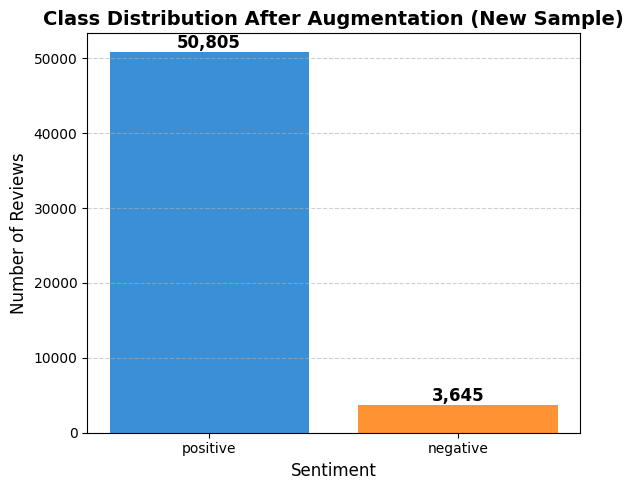

In [18]:
# ตรวจสอบจำนวนแต่ละคลาสก่อน export และ visualize

import matplotlib.pyplot as plt

# ตรวจสอบจำนวนแต่ละคลาสหลังสังเคราะห์
class_counts_final_newsample = augmented_df_newsample["sentiment"].value_counts()

print("\nจำนวนรีวิวต่อคลาส (หลังสังเคราะห์):")
print(class_counts_final_newsample)


# Visualize class distribution

plt.figure(figsize=(6, 5))
bars = plt.bar(
    class_counts_final_newsample.index,
    class_counts_final_newsample.values,
    color=['#187bcd', '#ff7f0e'],
    alpha=0.85
)

# เพิ่มตัวเลขบนแท่ง
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{int(bar.get_height()):,}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Class Distribution After Augmentation (New Sample)", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [19]:
output_path = "Augmented_train_data_newsample.csv"
augmented_df_newsample.to_csv(output_path, index=False, encoding="utf-8-sig")